# Create Synthetic Image Data for YOLOv5 annotation
Maximilian Palm 12.2021

## STEP 1: Install and Import Required Libraries

Have a look at the import statements below. Install any module you might not already have.

In [1]:
import os
import numpy as np
import skimage.io as io
import skimage.transform as transform
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.notebook import tqdm
from tqdm.notebook import trange
from os import walk
import random
from PIL import Image

from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

In [14]:
#labelindex does not work yet
"""
data_dict='{}'
data_dict= json.loads(data_dict)

data_dict['names']=[]
for label in label_list:
    data_dict['names'].append(str(label))
    
data_dict['nc']=len(label_list)

data_dict['val']="images/valid"
data_dict['test']="images/test"
data_dict['train']="images/train"
print(data_dict)
print(type(data_dict))

with open('output/data.yaml', 'w') as f:
    data = yaml.safe_dump(data_dict, f, default_flow_style=False)
"""


'\ndata_dict=\'{}\'\ndata_dict= json.loads(data_dict)\n\ndata_dict[\'names\']=[]\nfor label in label_list:\n    data_dict[\'names\'].append(str(label))\n    \ndata_dict[\'nc\']=len(label_list)\n\ndata_dict[\'val\']="images/valid"\ndata_dict[\'test\']="images/test"\ndata_dict[\'train\']="images/train"\nprint(data_dict)\nprint(type(data_dict))\n\nwith open(\'output/data.yaml\', \'w\') as f:\n    data = yaml.safe_dump(data_dict, f, default_flow_style=False)\n'

## Functions needed

In [2]:
### Apply augmentations on the foreground.

def foregroundAug(foreground):
    # Random rotation, zoom, translation
    angle = np.random.randint(-10,10)*(np.pi/180.0) # Convert to radians
    zoom = np.random.random()*0.8 + 0.4 # Zoom in range [0.8,1.2)
    t_x = np.random.randint(0, int(foreground.shape[1]/3))
    t_y = np.random.randint(0, int(foreground.shape[0]/3))

    tform = transform.AffineTransform(scale=(zoom,zoom),
                                rotation=angle,
                                translation=(t_x, t_y))
    foreground = transform.warp(foreground, tform.inverse)

    # Random horizontal flip with 0.5 probability
    if(np.random.randint(0,100)>=50):
        foreground = foreground[:, ::-1]
        
    return foreground

# Create a mask for this new foreground object
def getForegroundMask(foreground):
    mask_new = foreground.copy()[:,:,0]
    mask_new[mask_new>0] = 1
    return mask_new


def compose(foreground, mask, background):
    # resize background
    background = transform.resize(background, foreground.shape[:2])

    # Subtract the foreground area from the background
    background = background*(1 - mask.reshape(foreground.shape[0], foreground.shape[1], 1))

    # Finally, add the foreground
    composed_image = background + foreground
    
    return composed_image

def generate_image(img_path,bg_path,save_path,label_path):
    current_file=random.choice(file_list)
    #create image
    I = io.imread(img_path)/255.0

    try:
        I = I.copy()[:,:,:3]
    except:
        pass


    foreground = I.copy()
    foreground[foreground==1]=0

    foreground_new = foregroundAug(foreground)

    mask_new = getForegroundMask(foreground_new)

    background = io.imread(bg_path)/255.0
    try:
        background = background.copy()[:,:,:3]
    except:
        pass

    composed_image = compose(foreground_new, mask_new, background)
    composed_image = ndimage.uniform_filter(composed_image, size=(np.random.randint(0,15),np.random.randint(0,15),1))
    composed_image = random_noise(composed_image, mode='s&p',amount=np.random.random()*0.3)
    #creat_label
    create_label(mask_new,label_path)
    
    #save image
    io.imsave(save_path, (composed_image*255).astype(np.uint8))



def create_label(mask,path):
    nz = np.nonzero(mask)
    bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])]
    width = 1*(bbox[3] - bbox[1])/mask.shape[1]
    height = 1*(bbox[2] - bbox[0])/mask.shape[0]
    x = 1*bbox[1]/mask.shape[1]+width/2
    y = 1*bbox[0]/mask.shape[0]+height/2
    file = open(path, 'w')
    file.write(str(idx)+" "+str(x)+" "+str(y)+" "+str(width)+" "+str(height)+"\n")
    file.close()

# Demo Section to see how it works

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Blurring added')

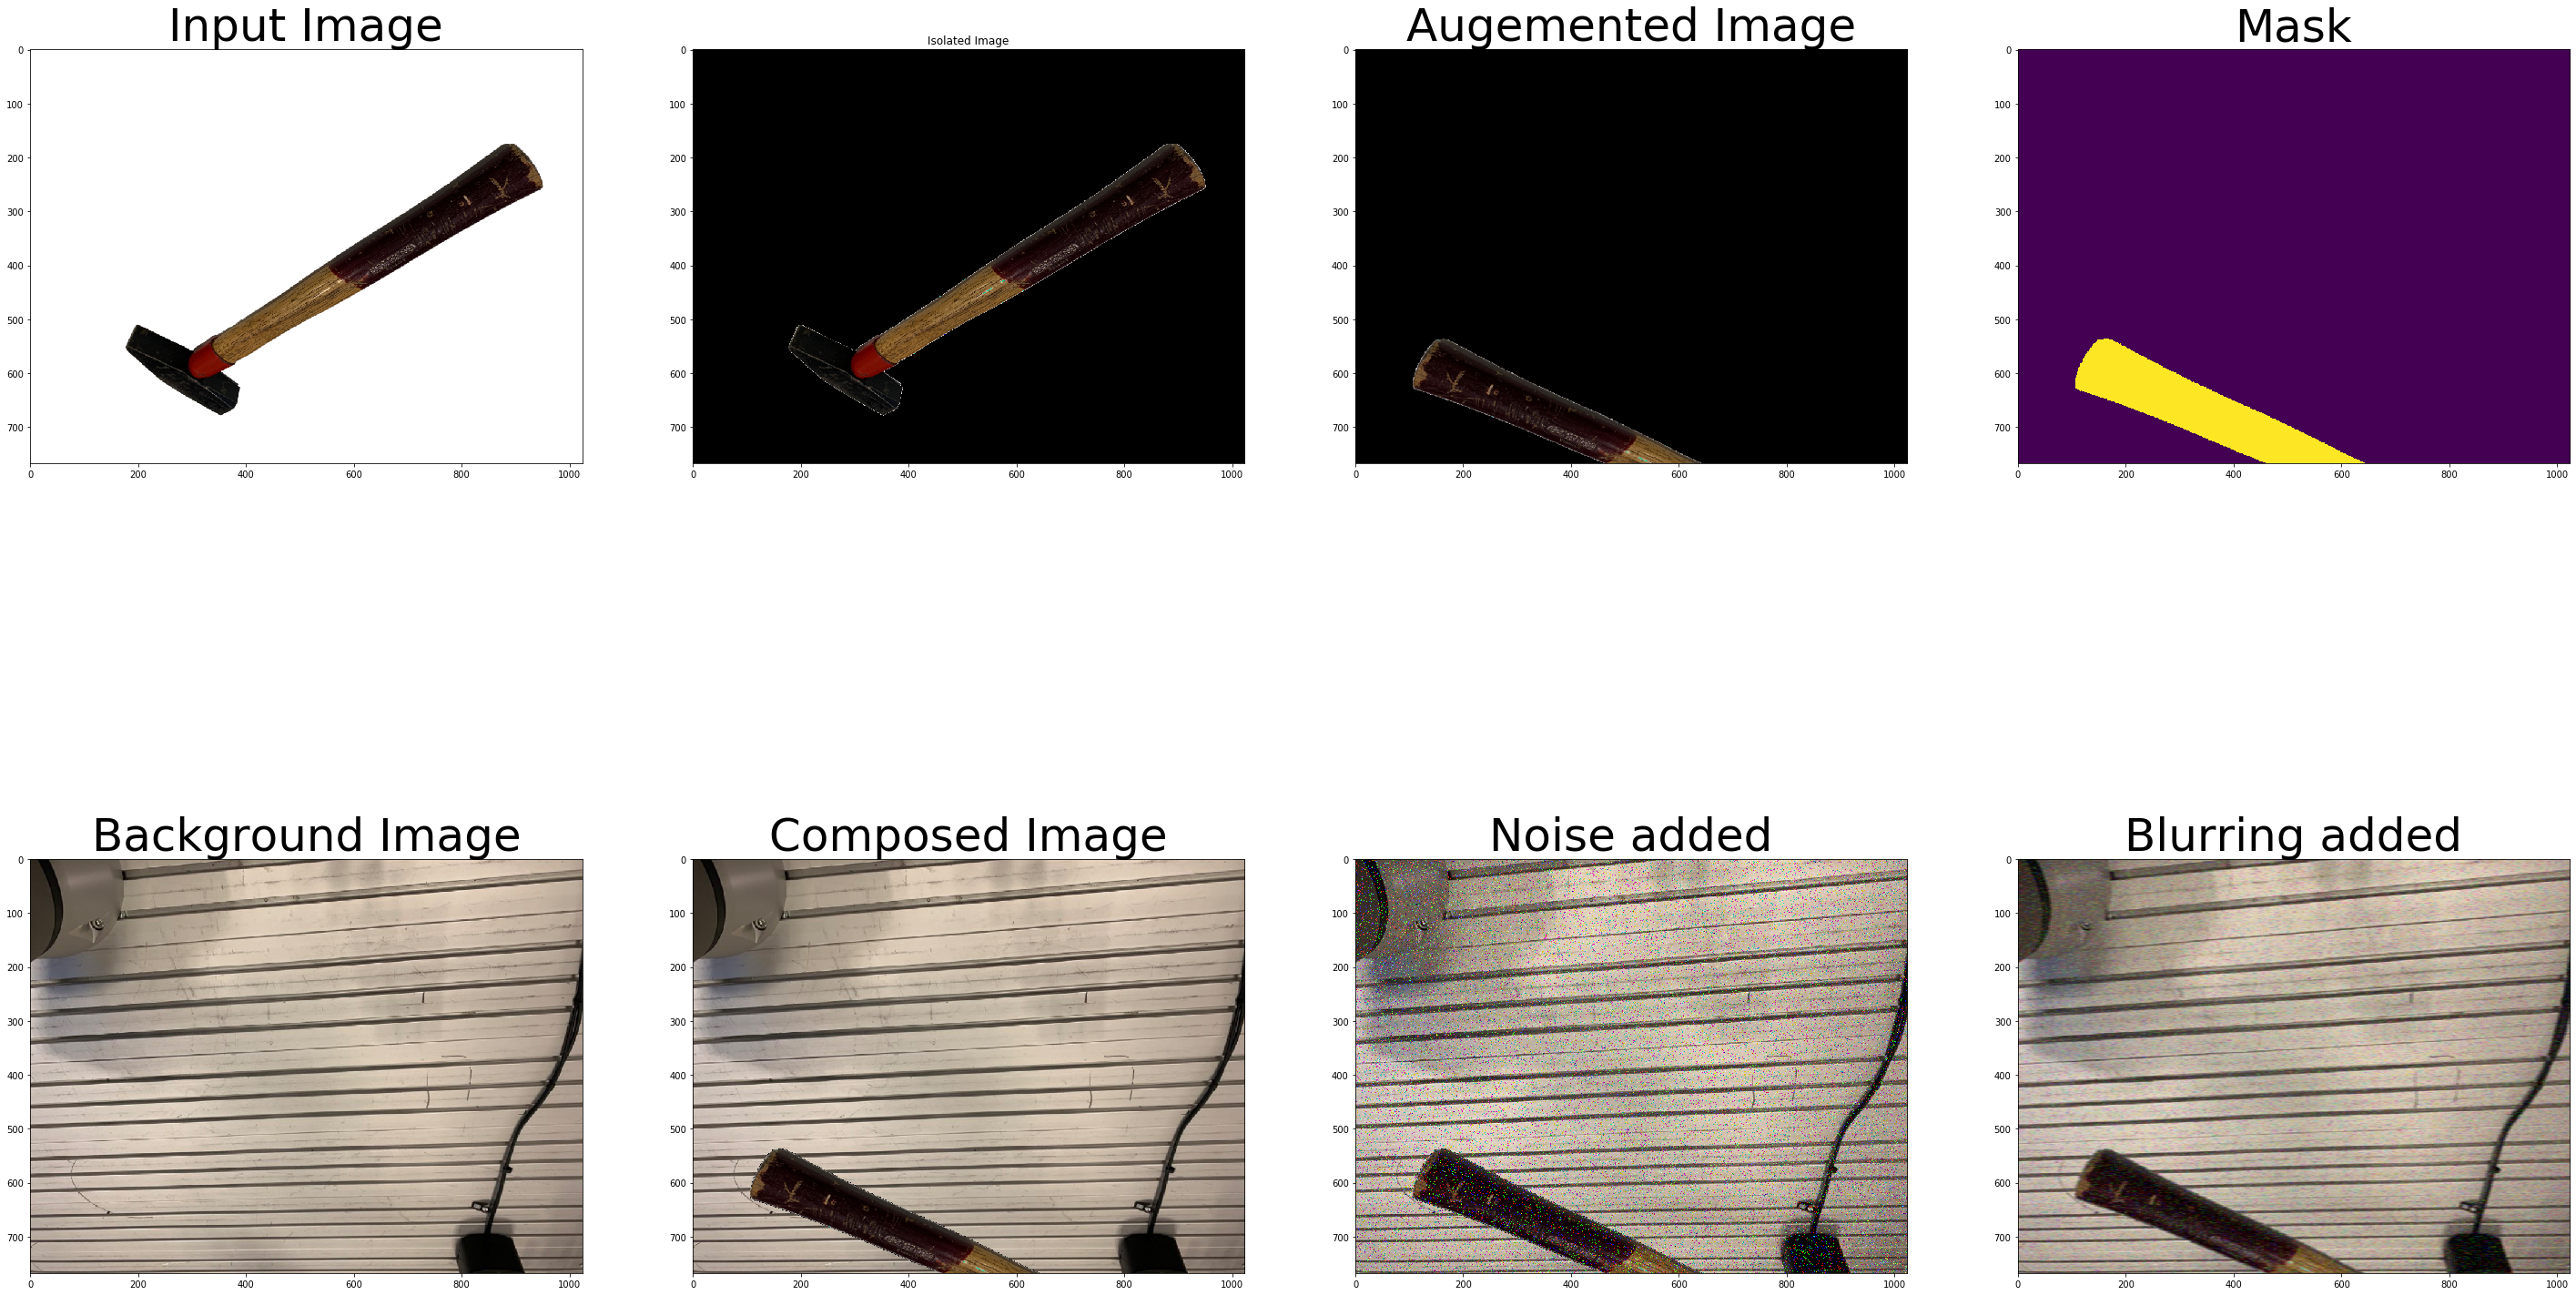

In [13]:
im_path='input/Hammer/IMG_0189 (Medium).png'
# Read the image
I = io.imread(im_path)/255.0


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(50, 30))

try:
    I = I.copy()[:,:,:3]
except:
    pass

axes[0, 0].imshow(I)
axes[0, 0].set_title('Input Image',size=50)

# Get only the foreground
foreground = I.copy()
foreground[foreground>=0.9]=0


axes[0, 1].imshow(foreground)
axes[0, 1].set_title('Isolated Image')

foreground_new = foregroundAug(foreground)
# Visualize the foreground

axes[0, 2].imshow(foreground_new)
axes[0, 2].set_title('Augemented Image',size=50)

mask_new = getForegroundMask(foreground_new)


axes[0, 3].imshow(mask_new)
axes[0, 3].set_title('Mask',size=50)

# Random selection of background from the folder
background_fileName = np.random.choice(os.listdir("./backgrounds/"))
background = io.imread('backgrounds/photo1639651246 (Medium).png')/255.0

# Visualize the background

axes[1, 0].imshow(background)
axes[1, 0].set_title('Background Image',size=50)

composed_image = compose(foreground_new, mask_new, background)

axes[1, 1].imshow(composed_image)
axes[1, 1].set_title('Composed Image',size=50)

#image Noising
composed_image = random_noise(composed_image, mode='s&p',amount=np.random.random()*0.3)


axes[1, 2].imshow(composed_image)
axes[1, 2].set_title('Noise added',size=50)

#blurring image
composed_image = ndimage.uniform_filter(composed_image, size=(np.random.randint(0,15),np.random.randint(0,15),1))


axes[1, 3].imshow(composed_image)
axes[1, 3].set_title('Blurring added',size=50)



# Specify parameters and execute this for a full run

In [3]:
train_percentage=0.8
test_percentage=0
validate_percentage=0.2


pic_per_label=200

number_train=round(pic_per_label*train_percentage)
number_test=round(pic_per_label*test_percentage)
number_val=pic_per_label-number_test-number_train

#Check that the percentages are correct
if(round(train_percentage+test_percentage+validate_percentage,2)!=1):
    raise AttributeError("The percentages from Train, Test and Validate do not add up to 1")

label_list=[]
#check how many labels were detected
for (dirpath, dirnames, filenames) in walk("input/"):
    label_list.extend(dirnames)
    
    break
print("Following labels found: ", label_list)    


for idx,label in enumerate(tqdm(label_list, position=0)):
    
    print("Folder: ", label)
    
    try:
        os.makedirs('output/images/valid/'+label)
    except OSError as e:
        pass
    
    try:
        os.makedirs('output/images/train/'+label)
    except OSError as e:
        pass
    
    try:
        os.makedirs('output/images/test/'+label)
    except OSError as e:
        pass
    
    try:
        os.makedirs('output/labels/train/'+label)
    except OSError as e:
        pass
    
    try:
        os.makedirs('output/labels/test/'+label)
    except OSError as e:
        pass
    
    try:
        os.makedirs('output/labels/valid/'+label)
    except OSError as e:
        pass
    
    
    
    file_list=[]
    for (dirpath, dirnames, filenames) in walk("input/"+label):
        file_list.extend(filenames)
    
    print("Train data")
    for i in trange(number_train, position=1):
        #select random image and background
        current_file=random.choice(file_list)
        background_fileName = np.random.choice(os.listdir("./backgrounds/"))
        
        #generate path
        image_path=os.path.join("input",label,f'{current_file}')
        bg_path='./backgrounds/'+background_fileName
        
        save_path=os.path.join("output/images/train/",label,f'{label}_{str(i)}.png')
        
        label_path=os.path.join("output/labels/train/",label,f'{label}_{str(i)}.txt')
        
        #compose image
        generate_image(image_path,bg_path,save_path,label_path)
        
    print("Test data")    
    for i in trange(number_test, position=1):
        #select random image and background
        current_file=random.choice(file_list)
        background_fileName = np.random.choice(os.listdir("./backgrounds/"))
        
        #generate path
        image_path=os.path.join("input",label,f'{current_file}')
        bg_path='./backgrounds/'+background_fileName
        
        save_path=os.path.join("output/images/test/",label,f'{label}_{str(i)}.png')
        
        label_path=os.path.join("output/labels/test/",label,f'{label}_{str(i)}.txt')
        
        #compose image
        generate_image(image_path,bg_path,save_path,label_path)
        
    print("Validation data")   
    for i in trange(number_val, position=1):
        #select random image and background
        current_file=random.choice(file_list)
        background_fileName = np.random.choice(os.listdir("./backgrounds/"))
        
        #generate path
        image_path=os.path.join("input",label,f'{current_file}')
        bg_path='./backgrounds/'+background_fileName
        
        save_path=os.path.join("output/images/valid/",label,f'{label}_{str(i)}.png')
        
        label_path=os.path.join("output/labels/valid/",label,f'{label}_{str(i)}.txt')
        
        #compose image
        try:
            generate_image(image_path,bg_path,save_path,label_path)
        except:
            print("Error in img: ",image_path," with background: ",bg_path)
        
        



Following labels found:  ['FI-Schalter', 'Hammer', 'Schraubblock', 'Schraubendreher', 'Schuetze']


Folder:  FI-Schalter
Train data



Test data



Validation data



Folder:  Hammer
Train data



Test data



Validation data



Folder:  Schraubblock
Train data



Test data



Validation data



Folder:  Schraubendreher
Train data



Test data



Validation data



Folder:  Schuetze
Train data



Test data



Validation data
